In [1]:
# import the libraries and load the dataset
import pandas as pd
# import the rest of the libraies/packages
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [2]:
df = pd.read_csv("e_commerce.csv",encoding="latin-1")
df.head(3)

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,type,color,size,rating,noofratings
0,"Carlton London Incense Eau da parfum, Premium ...",Flipkart,India,body,perfume,https://www.amazon.in/Carlton-London-Limited-I...,599.0,Carlton London,NaN,aerosol,NaN,"Top Note: Orange Blossom, Blackberry | Heart N...",100,3.9,19
1,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,149.0,Charlene,NaN,aerosol,NaN,Unit count type:,30,4.4,"4,031"
2,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,298.0,Charlene,NaN,aerosol,NaN,Unit count type:,30,4.4,"4,072"


In [3]:
def sizeclean(point):
    if type(point)==str:
        point=point.split(" ")[0]
        point=float(point)
    return point

In [4]:
df['size']=df['size'].apply(sizeclean)

In [5]:
# Convert the 'size' column to numeric, forcing errors to NaN
df['size'] = pd.to_numeric(df['size'], errors='coerce')

In [6]:
# Fill 'No type' for records with blank type value
df['type'] = df['type'].fillna('No type')
# Group by 'category' & 'subcategory' and fill NaN values with the mean of the group
df['size_cv'] = df.groupby(['category','subcategory'])['size'].transform(lambda x: x.fillna(x.mean()))
df['price_cv'] = df.groupby(['category','subcategory'])['price'].transform(lambda x: x.fillna(x.mean()))
df.isna().sum()

product_name       0
website            0
country            0
category           0
subcategory        0
title-href         0
price            317
brand              0
ingredients     6015
form               0
type               0
color           1989
size            3166
rating          2067
noofratings      459
size_cv            0
price_cv           0
dtype: int64

In [7]:
df.shape

(12615, 17)

Text(0.5, 1.0, 'Size_cv by Category')

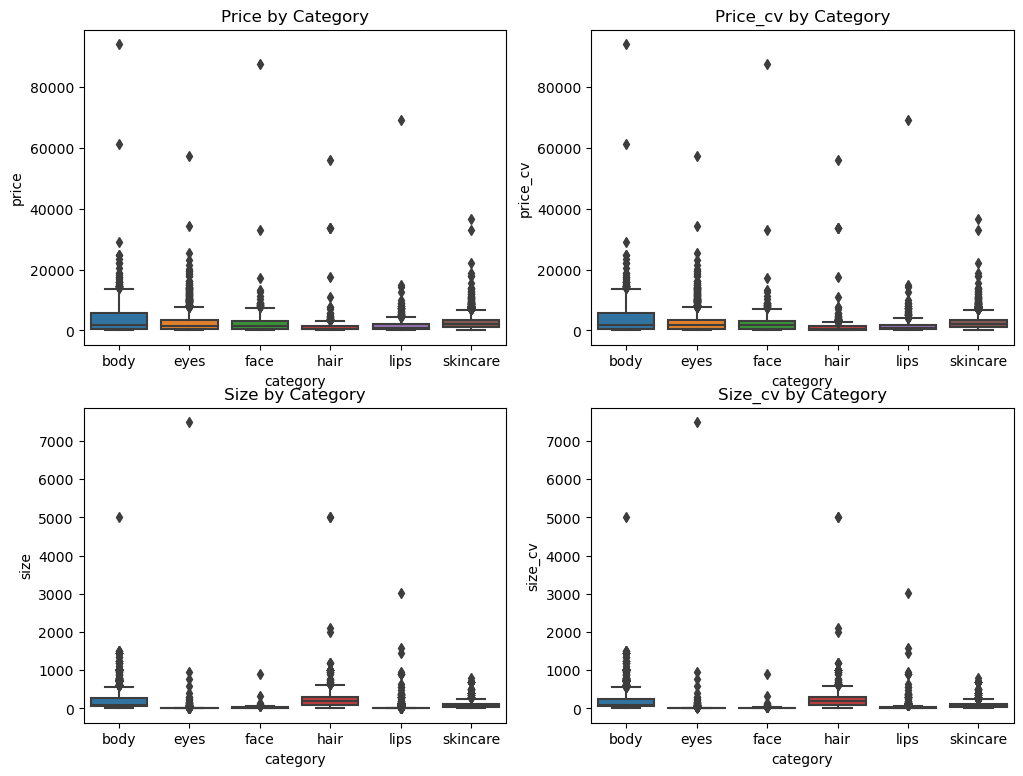

In [8]:
# check if the value after imputed with mean still have the same distribution
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))
sns.boxplot(ax=axes[0,0],x='category', y='price', data=df).set_title('Price by Category')
sns.boxplot(ax=axes[0,1],x='category', y='price_cv', data=df).set_title('Price_cv by Category')
sns.boxplot(ax=axes[1,0],x='category', y='size', data=df).set_title('Size by Category')
sns.boxplot(ax=axes[1,1],x='category', y='size_cv', data=df).set_title('Size_cv by Category')

**Option 1: Classify brand by price across all products**

In [9]:
def classify_price(price):
    if price > 10000:
        return 'luxury brand'
    elif price < 2860:
        return 'budget'
    elif 2860 <= price <= 10000:
        return 'mid tier'
df['brand_group'] = df['price_cv'].apply(classify_price)

luxury_count = df[df['brand_group'] == 'luxury brand'].shape[0]
budget_count = df[df['brand_group'] == 'budget'].shape[0]
mid_tier_count = df[df['brand_group'] == 'mid tier'].shape[0]

print(luxury_count,mid_tier_count,budget_count,luxury_count+mid_tier_count+budget_count )
# print(df)

296 2792 9527 12615


**Option 2: Classify brand/product class by price percentile in each category**

In [10]:
# Function to classify based on percentiles
def classify_price(x):
    if x <= 0.6:
        return 'Regular'
    elif x <= 0.95:
        return 'Premium'
    else:
        return 'Super Premium'

In [11]:
# The groupby method is used to group the DataFrame by the brand column.
# The transform method along with rank(pct=True) calculates the percentile rank for each price within its brand group
df['percentile'] = df.groupby('category')['price_cv'].transform(lambda x: x.rank(pct=True))

df['product_class'] = df['percentile'].apply(classify_price)

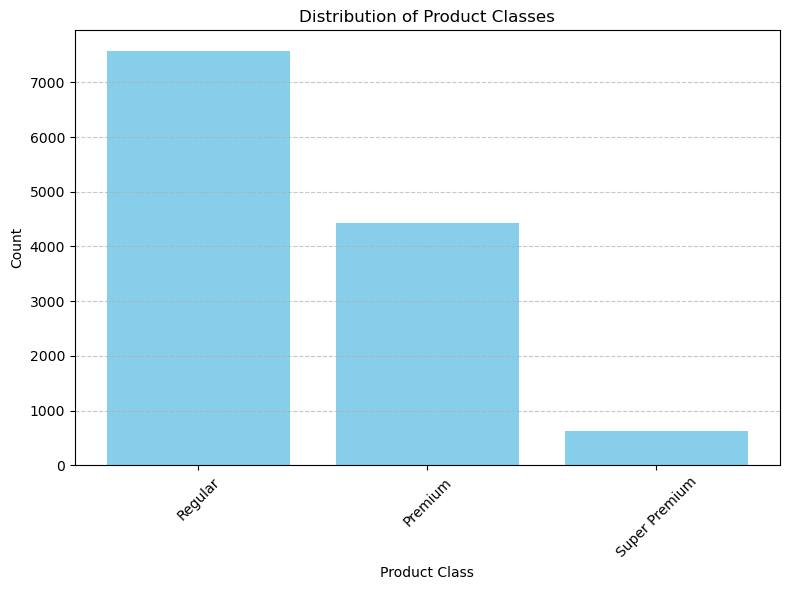

In [12]:
# Create a count plot (bar chart)
plt.figure(figsize=(8, 6))
plt.title('Distribution of Product Classes')
plt.xlabel('Product Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot the counts
plt.bar(df['product_class'].value_counts().index, df['product_class'].value_counts().values, color='skyblue')

# Show the plot
plt.tight_layout()
plt.show()

In [13]:
# Group by brand and product_class, and count occurrences
product_class_counts = df.groupby(['brand', 'product_class']).size().reset_index(name='count')

# Find the product class with the maximum count for each brand
max_product_class = product_class_counts.loc[product_class_counts.groupby('brand')['count'].idxmax()]

# Reset index for the final DataFrame
max_product_class = max_product_class.reset_index(drop=True)
max_product_class.rename(columns={'product_class':'brand_class'}, inplace=True)
print(max_product_class.shape, df.brand.nunique())
max_product_class.head(3)

(1753, 3) 1753


,brand,brand_class,count
0,100% PURE,Premium,1
1,1000Hour,Premium,1
2,18.21 Man Made,Regular,1


In [14]:
df = df.merge(max_product_class[['brand', 'brand_class']], on = 'brand', how = 'left')
df.head()

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,...,color,size,rating,noofratings,size_cv,price_cv,brand_group,percentile,product_class,brand_class
0,"Carlton London Incense Eau da parfum, Premium ...",Flipkart,India,body,perfume,https://www.amazon.in/Carlton-London-Limited-I...,599.0,Carlton London,NaN,aerosol,...,"Top Note: Orange Blossom, Blackberry | Heart N...",100.0,3.9,19,100.0,599.0,budget,0.257926,Regular,Regular
1,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,149.0,Charlene,NaN,aerosol,...,Unit count type:,30.0,4.4,"4,031",30.0,149.0,budget,0.030528,Regular,Regular
2,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,298.0,Charlene,NaN,aerosol,...,Unit count type:,30.0,4.4,"4,072",30.0,298.0,budget,0.120352,Regular,Regular
3,DENVER Black Code Perfume - 60 | Eau de Parfum...,Flipkart,India,body,perfume,https://www.amazon.in/DENVER-Black-Code-Perfum...,245.0,Denver,NaN,aerosol,...,Long-Lasting Scent,60.0,4.2,61,60.0,245.0,budget,0.087084,Regular,Regular
4,Denver Hamilton Perfume - 100 | Long Lasting P...,Flipkart,India,body,perfume,https://www.amazon.in/Denver-Perfume-Hamilton-...,422.0,Denver,NaN,aerosol,...,Long-Lasting Scent,100.0,4.3,342,100.0,422.0,budget,0.194912,Regular,Regular


**rating/noofratings Column Transform:**  if noofratings is blank & rating >10, then rating is noofratings. For the rest impute missing values using mean/median of the sub-category

In [15]:
df['rating'] = df['rating'].str.split(" ").str[0]
df['rating'] = df['rating'].str.replace(',', '')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
incorrect_ratings = df['rating'] > 10
df.loc[incorrect_ratings, 'noofratings'] = df.loc[incorrect_ratings, 'rating']
df.loc[incorrect_ratings, 'rating'] = 0

In [16]:
def ratingno(point):
    if point in ('Write A Review','No reviews','New to Amazon'):
        point = 0
    elif type(point)==str:
        point=point.split(" ")[0]
        point=point.replace(",","")
        point=float(point)
    return point
df['noofratings_cv']=df['noofratings'].apply(ratingno)

In [17]:
df['rating'] = df.groupby('subcategory')['rating'].transform(lambda x: x.fillna(x.mean()).mask((x == 0) | (x > 5), x.mean()))
df['rating'] = df['rating'].round(1)

In [18]:
print(df.shape)
df.isna().sum()

(12615, 22)


product_name         0
website              0
country              0
category             0
subcategory          0
title-href           0
price              317
brand                0
ingredients       6015
form                 0
type                 0
color             1989
size              3166
rating             674
noofratings        405
size_cv              0
price_cv             0
brand_group          0
percentile           0
product_class        0
brand_class          0
noofratings_cv     405
dtype: int64

In [19]:
df.head(5)

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,...,size,rating,noofratings,size_cv,price_cv,brand_group,percentile,product_class,brand_class,noofratings_cv
0,"Carlton London Incense Eau da parfum, Premium ...",Flipkart,India,body,perfume,https://www.amazon.in/Carlton-London-Limited-I...,599.0,Carlton London,NaN,aerosol,...,100.0,3.9,19,100.0,599.0,budget,0.257926,Regular,Regular,19.0
1,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,149.0,Charlene,NaN,aerosol,...,30.0,4.4,"4,031",30.0,149.0,budget,0.030528,Regular,Regular,4031.0
2,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,298.0,Charlene,NaN,aerosol,...,30.0,4.4,"4,072",30.0,298.0,budget,0.120352,Regular,Regular,4072.0
3,DENVER Black Code Perfume - 60 | Eau de Parfum...,Flipkart,India,body,perfume,https://www.amazon.in/DENVER-Black-Code-Perfum...,245.0,Denver,NaN,aerosol,...,60.0,4.2,61,60.0,245.0,budget,0.087084,Regular,Regular,61.0
4,Denver Hamilton Perfume - 100 | Long Lasting P...,Flipkart,India,body,perfume,https://www.amazon.in/Denver-Perfume-Hamilton-...,422.0,Denver,NaN,aerosol,...,100.0,4.3,342,100.0,422.0,budget,0.194912,Regular,Regular,342.0


In [20]:
ingredients = df[df['ingredients'].notna()]
ingredients

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,...,size,rating,noofratings,size_cv,price_cv,brand_group,percentile,product_class,brand_class,noofratings_cv
17,Deadsea Mud Purifying Mud Soap,ulta,USA,body,bodywash,https://www.ulta.com/p/deadsea-mud-purifying-m...,980.4,Ahava,"Pottasium Lauryl Sulfate, Disodium Lauryl Sulf...",cream,...,102.0,4.7,28,102.0,980.4,budget,0.382192,Regular,Regular,28.0
18,Natural Dead Sea Bath Salts,ulta,USA,body,bodywash,https://www.ulta.com/p/natural-dead-sea-bath-s...,980.4,Ahava,100% Dead Sea salt,cream,...,255.0,4.0,1,255.0,980.4,budget,0.382192,Regular,Regular,1.0
19,Superfood Shower Gel Kale & Turmeric,ulta,USA,body,bodywash,https://www.ulta.com/p/superfood-shower-gel-ka...,1960.8,Ahava,"Aqua (Mineral Spring Water), Ammonium Lauryl S...",cream,...,0.0,4.0,NaN,0.0,1960.8,budget,0.508806,Regular,Regular,NaN
20,Sea-Kissed Mineral Shower Gel,ulta,USA,body,bodywash,https://www.ulta.com/p/sea-kissed-mineral-show...,1960.8,Ahava,"Aqua (Mineral Spring Water), Ammonium Lauryl S...",cream,...,204.0,4.7,13,204.0,1960.8,budget,0.508806,Regular,Regular,13.0
21,Mineral Botanic Velvet Cream Wash,ulta,USA,body,bodywash,https://www.ulta.com/p/mineral-botanic-velvet-...,1960.8,Ahava,"Aqua (Water), Ammonium Laureth Sulfate, Cocami...",cream,...,510.0,4.7,301,510.0,1960.8,budget,0.508806,Regular,Regular,301.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12610,Bright Future - Smoothing & Brightening Concea...,Sephora,India,face,concealer,https://sephora.nnnow.com/mac-cosmetics-prep--...,1900.0,MAC Cosmetics,"Water\Aqua\Eau, Glycerin, Butylene Glycol, Toc...",cream,...,100.0,3.2,14,100.0,1900.0,budget,0.538315,Regular,Premium,14.0
12611,Bright Future - Smoothing & Brightening Concea...,Sephora,India,face,concealer,https://sephora.nnnow.com/mac-cosmetics-prep--...,2150.0,MAC Cosmetics,"Water\Aqua\Eau, Cyclopentasiloxane, Dimethicon...",cream,...,100.0,3.1,13,100.0,2150.0,budget,0.559215,Regular,Premium,13.0
12612,Starlaa Rosy Bronze Blush Mini,Sephora,India,face,blush,https://sephora.nnnow.com/klara-cosmetics-wome...,3040.0,Klara Cosmetics,"Talc, Ethylhexyl Palmitate, Octyldodecanol, Sy...",powder,...,110.0,4.0,96,110.0,3040.0,mid tier,0.734009,Premium,Premium,96.0
12613,Terra Golden Brick Red Blush Travel Size Mini,Sephora,India,face,blush,https://sephora.nnnow.com/clinique-women-clini...,2950.0,CLINIQUE,"Water\Aqua\Eau, Dimethicone, Isododecane, Buty...",liquid,...,115.0,3.2,15,115.0,2950.0,mid tier,0.713110,Premium,Premium,15.0


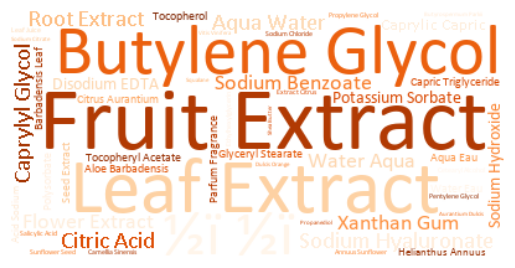

In [21]:
skin_care = ingredients[ingredients['category'] == 'skincare']
wordcloud = WordCloud(background_color='white',colormap='Oranges',
                      collocations=True, max_words=50, font_path='calibri').generate(' '.join(skin_care['ingredients']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
skin_care['first_ingredient'] = skin_care['ingredients'].apply(lambda x: x.split(',')[0].strip())

skin_care

C:\Users\LAPTOP\AppData\Local\Temp\ipykernel_12160\1310148476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skin_care['first_ingredient'] = skin_care['ingredients'].apply(lambda x: x.split(',')[0].strip())


,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,...,rating,noofratings,size_cv,price_cv,brand_group,percentile,product_class,brand_class,noofratings_cv,first_ingredient
8960,Shanta Rich Facial Cleanser,Sephora,India,skincare,cleanser,https://sephora.nnnow.com/abhati-suisse-shanta...,3100.00,ABHATi SUISSE,"Aqua (Water), Glycerin (Vegetable), Lauryl Glu...",cream,...,4.2,14,75.00,3100.00,mid tier,0.709677,Premium,Premium,14.0,Aqua (Water)
8961,Brightening Day Cream,ulta,USA,skincare,moisturizer,https://www.ulta.com/p/brightening-day-cream-p...,1633.38,ACURE,"Water (Aqua), Carthamus Tinctorius (Safflower)...",cream,...,4.4,74,51.00,1633.38,budget,0.422725,Regular,Regular,74.0,Water (Aqua)
8962,Radically Rejuvenating SPF 30 Day Cream,ulta,USA,skincare,moisturizer,https://www.ulta.com/p/radically-rejuvenating-...,1633.38,ACURE,"Zinc Oxide 15%., Allantoin, Aloe Barbadensis (...",cream,...,2.8,199,51.00,1633.38,budget,0.422725,Regular,Regular,199.0,Zinc Oxide 15%.
8963,Night Replenisher Normal to Dry,ulta,USA,skincare,eye treatment,https://www.ulta.com/p/night-replenisher-norma...,4248.92,Ahava,"Aqua (Water), Ethylhexyl Palmitate, Propanedio...",cream,...,4.3,39,51.00,4248.92,mid tier,0.832210,Premium,Regular,39.0,Aqua (Water)
8964,Essential Day Moisturizer Combination,ulta,USA,skincare,moisturizer,https://www.ulta.com/p/essential-day-moisturiz...,4248.92,Ahava,"Aqua (Mineral Spring Water), Hexyldecyl Laurat...",cream,...,4.7,69,51.00,4248.92,mid tier,0.832210,Premium,Regular,69.0,Aqua (Mineral Spring Water)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11029,NIGHT OFF FACE WASH Green Tea Deep Cleanser,ulta,USA,skincare,face wash,https://www.ulta.com/p/night-off-face-wash-gre...,2614.40,Youthforia,"Water, Coco-glucoside, Glycerin, Potassium Coc...",liquid,...,4.9,138,99.00,2614.40,budget,0.631921,Premium,Premium,138.0,Water
11030,KILLA Kit Deep Zit Microdart Patch,ulta,USA,skincare,serum,https://www.ulta.com/p/killa-kit-deep-zit-micr...,2369.59,ZitSticka,"Sodium Hyaluronate, Oligopeptide-76, Niacinami...",liquid,...,4.7,"11,680",1.68,2369.59,budget,0.581608,Regular,Premium,11680.0,Sodium Hyaluronate
11031,CUSHION CLEANSE Barrier-Strengthening Cleanser...,ulta,USA,skincare,cleanser,https://www.ulta.com/p/cushion-cleanse-barrier...,2859.50,ZitSticka,"Water (Aqua), Glycerin, Decyl Glucoside, Coco-...",liquid,...,5.0,2,141.90,2859.50,budget,0.678623,Premium,Premium,2.0,Water (Aqua)
11035,NUDESKIN Vegan Bamboo Cleansing Cloths,ulta,USA,skincare,cleanser,https://www.ulta.com/p/nudeskin-vegan-bamboo-c...,2451.00,NUDESTIX,"Water (Aqua), Caprylic/Capric Triglyceride, So...",wipes,...,3.0,7,12.60,2451.00,budget,0.601348,Premium,Premium,7.0,Water (Aqua)


In [23]:
def get_second_ingredient(ingredients):
    parts = ingredients.split(',')
    return parts[1].strip() if len(parts) > 1 else None

skin_care['second_ingredient'] = skin_care['ingredients'].apply(get_second_ingredient)
skin_care

C:\Users\LAPTOP\AppData\Local\Temp\ipykernel_12160\4009307493.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skin_care['second_ingredient'] = skin_care['ingredients'].apply(get_second_ingredient)


,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,...,noofratings,size_cv,price_cv,brand_group,percentile,product_class,brand_class,noofratings_cv,first_ingredient,second_ingredient
8960,Shanta Rich Facial Cleanser,Sephora,India,skincare,cleanser,https://sephora.nnnow.com/abhati-suisse-shanta...,3100.00,ABHATi SUISSE,"Aqua (Water), Glycerin (Vegetable), Lauryl Glu...",cream,...,14,75.00,3100.00,mid tier,0.709677,Premium,Premium,14.0,Aqua (Water),Glycerin (Vegetable)
8961,Brightening Day Cream,ulta,USA,skincare,moisturizer,https://www.ulta.com/p/brightening-day-cream-p...,1633.38,ACURE,"Water (Aqua), Carthamus Tinctorius (Safflower)...",cream,...,74,51.00,1633.38,budget,0.422725,Regular,Regular,74.0,Water (Aqua),Carthamus Tinctorius (Safflower)
8962,Radically Rejuvenating SPF 30 Day Cream,ulta,USA,skincare,moisturizer,https://www.ulta.com/p/radically-rejuvenating-...,1633.38,ACURE,"Zinc Oxide 15%., Allantoin, Aloe Barbadensis (...",cream,...,199,51.00,1633.38,budget,0.422725,Regular,Regular,199.0,Zinc Oxide 15%.,Allantoin
8963,Night Replenisher Normal to Dry,ulta,USA,skincare,eye treatment,https://www.ulta.com/p/night-replenisher-norma...,4248.92,Ahava,"Aqua (Water), Ethylhexyl Palmitate, Propanedio...",cream,...,39,51.00,4248.92,mid tier,0.832210,Premium,Regular,39.0,Aqua (Water),Ethylhexyl Palmitate
8964,Essential Day Moisturizer Combination,ulta,USA,skincare,moisturizer,https://www.ulta.com/p/essential-day-moisturiz...,4248.92,Ahava,"Aqua (Mineral Spring Water), Hexyldecyl Laurat...",cream,...,69,51.00,4248.92,mid tier,0.832210,Premium,Regular,69.0,Aqua (Mineral Spring Water),Hexyldecyl Laurate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11029,NIGHT OFF FACE WASH Green Tea Deep Cleanser,ulta,USA,skincare,face wash,https://www.ulta.com/p/night-off-face-wash-gre...,2614.40,Youthforia,"Water, Coco-glucoside, Glycerin, Potassium Coc...",liquid,...,138,99.00,2614.40,budget,0.631921,Premium,Premium,138.0,Water,Coco-glucoside
11030,KILLA Kit Deep Zit Microdart Patch,ulta,USA,skincare,serum,https://www.ulta.com/p/killa-kit-deep-zit-micr...,2369.59,ZitSticka,"Sodium Hyaluronate, Oligopeptide-76, Niacinami...",liquid,...,"11,680",1.68,2369.59,budget,0.581608,Regular,Premium,11680.0,Sodium Hyaluronate,Oligopeptide-76
11031,CUSHION CLEANSE Barrier-Strengthening Cleanser...,ulta,USA,skincare,cleanser,https://www.ulta.com/p/cushion-cleanse-barrier...,2859.50,ZitSticka,"Water (Aqua), Glycerin, Decyl Glucoside, Coco-...",liquid,...,2,141.90,2859.50,budget,0.678623,Premium,Premium,2.0,Water (Aqua),Glycerin
11035,NUDESKIN Vegan Bamboo Cleansing Cloths,ulta,USA,skincare,cleanser,https://www.ulta.com/p/nudeskin-vegan-bamboo-c...,2451.00,NUDESTIX,"Water (Aqua), Caprylic/Capric Triglyceride, So...",wipes,...,7,12.60,2451.00,budget,0.601348,Premium,Premium,7.0,Water (Aqua),Caprylic/Capric Triglyceride


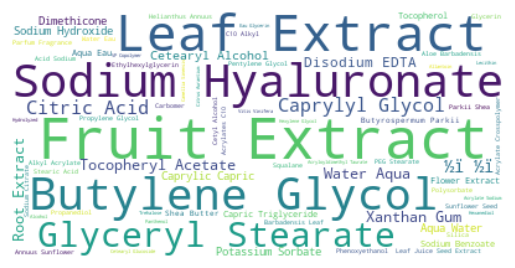

In [24]:
moisturizer = skin_care[skin_care['subcategory'] == 'moisturizer']
wordcloud = WordCloud(background_color='white').generate(' '.join(moisturizer['ingredients']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

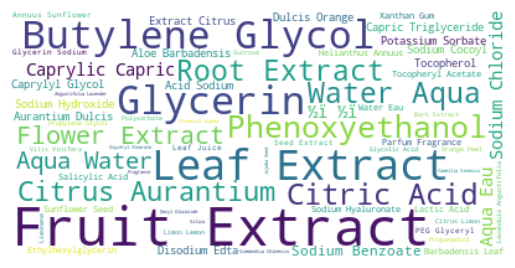

In [25]:
cleanser = skin_care[skin_care['subcategory'] == 'cleanser']
wordcloud = WordCloud(background_color='white').generate(' '.join(cleanser['ingredients']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

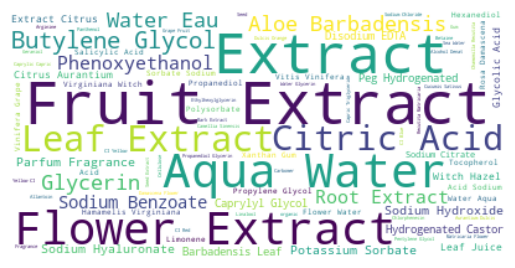

In [26]:
toner = skin_care[skin_care['subcategory'] == 'toner']
wordcloud = WordCloud(background_color='white').generate(' '.join(toner['ingredients']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

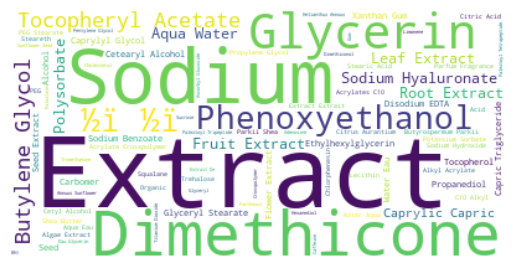

In [27]:
eye = skin_care[skin_care['subcategory'] == 'eye treatment']
wordcloud = WordCloud(background_color='white').generate(' '.join(eye['ingredients']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

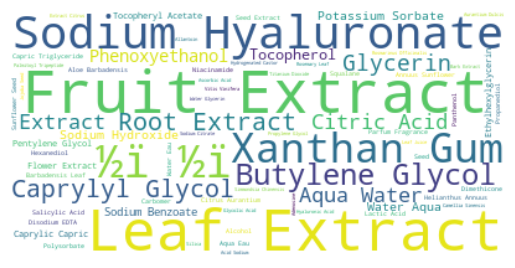

In [28]:
serum = skin_care[skin_care['subcategory'] == 'serum']
wordcloud = WordCloud(background_color='white').generate(' '.join(serum['ingredients']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

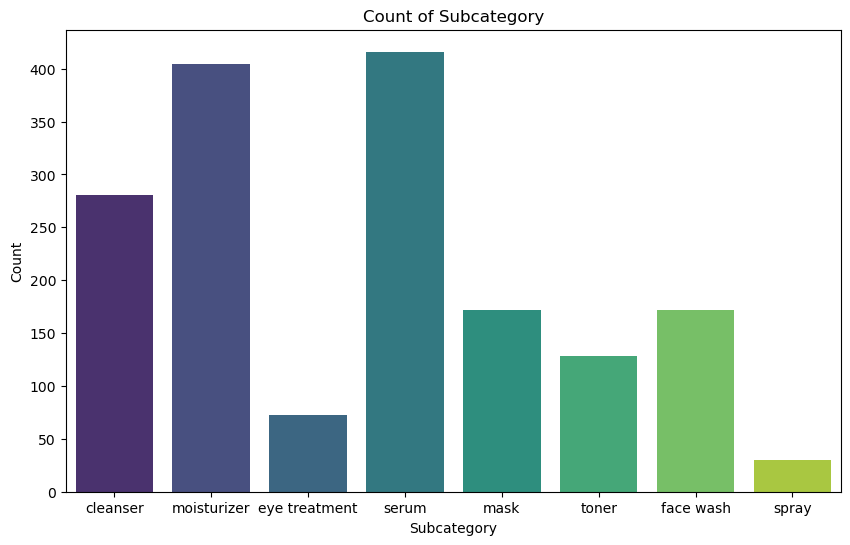

In [29]:
plt.figure(figsize=(10, 6))
sns.countplot(data=skin_care, x='subcategory', palette='viridis')
plt.title('Count of Subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.show()

In [30]:
face_wash = skin_care[skin_care['subcategory'] == 'face wash']
face_wash

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,...,noofratings,size_cv,price_cv,brand_group,percentile,product_class,brand_class,noofratings_cv,first_ingredient,second_ingredient
9940,Brightening Cleansing Gel,ulta,USA,skincare,face wash,https://www.ulta.com/p/brightening-cleansing-g...,897.88,ACURE,"Water (Aqua), Cocamidopropyl Betaine, Lauryl G...",liquid,...,171,120.0,897.88,budget,0.241213,Regular,Regular,171.0,Water (Aqua),Cocamidopropyl Betaine
9941,Ultra Hydrating Green Juice Cleanser,ulta,USA,skincare,face wash,https://www.ulta.com/p/ultra-hydrating-green-j...,1142.98,ACURE,"Water (Aqua), Sodium Cocoyl Isethionate, Glyce...",liquid,...,101,120.0,1142.98,budget,0.297785,Regular,Regular,101.0,Water (Aqua),Sodium Cocoyl Isethionate
9944,Refreshing Face Wash,ulta,USA,skincare,face wash,https://www.ulta.com/p/refreshing-face-wash-xl...,734.48,Alpha Skin Care,"Water, Decyl Glucoside, Cocamidopropyl Betaine...",liquid,...,87,180.0,734.48,budget,0.193789,Regular,Regular,87.0,Water,Decyl Glucoside
9945,1000 Roses Cleansing Foam,ulta,USA,skincare,face wash,https://www.ulta.com/p/1000-roses-cleansing-fo...,1224.68,Andalou Naturals,"Aloe Barbadensis Leaf Juice, Water (aqua), Ros...",liquid,...,91,18.0,1224.68,budget,0.318729,Regular,Regular,91.0,Aloe Barbadensis Leaf Juice,Water (aqua)
9949,Brightening Meyer Lemon C Creamy Cleanser,ulta,USA,skincare,face wash,https://www.ulta.com/p/brightening-meyer-lemon...,1306.38,Andalou Naturals,"Aloe Barbadensis Leaf Juice, Water (Aqua), Sod...",liquid,...,13,180.0,1306.38,budget,0.338710,Regular,Regular,13.0,Aloe Barbadensis Leaf Juice,Water (Aqua)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10998,Puretï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ Thermale Fre,ulta,USA,skincare,face wash,https://www.ulta.com/p/purete-thermale-fresh-c...,1593.15,Vichy,"Aqua / Water, Glycerin, Coco-Betaine, Sodium C...",liquid,...,172,201.0,1593.15,budget,0.410448,Regular,Premium,172.0,Aqua / Water,Glycerin
10999,Puretï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ Thermale One Step Face...,ulta,USA,skincare,face wash,https://www.ulta.com/p/purete-thermale-one-ste...,1593.15,Vichy,"Water, Paraffinum Liquidum/Mineral , Isopropyl...",liquid,...,131,201.0,1593.15,budget,0.410448,Regular,Premium,131.0,Water,Paraffinum Liquidum/Mineral
11003,Normaderm Phytoaction Daily Deep Cleansing Gel...,ulta,USA,skincare,face wash,https://www.ulta.com/p/normaderm-phytoaction-d...,1878.28,Vichy,"Salicylic Acid 0.5%. InWater, Coco-Betaine, Pr...",liquid,...,385,201.0,1878.28,budget,0.470390,Regular,Premium,385.0,Salicylic Acid 0.5%. InWater,Coco-Betaine
11019,Patchouli + Cherimoya Gel Cleanser,ulta,USA,skincare,face wash,https://www.ulta.com/p/patchouli-cherimoya-gel...,1634.00,WLDKAT,"Water (Aqua), Sodium Lauroyl Methyl Isethionat...",liquid,...,21,120.0,1634.00,budget,0.428743,Regular,Regular,21.0,Water (Aqua),Sodium Lauroyl Methyl Isethionate


In [31]:
skin_care

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,...,noofratings,size_cv,price_cv,brand_group,percentile,product_class,brand_class,noofratings_cv,first_ingredient,second_ingredient
8960,Shanta Rich Facial Cleanser,Sephora,India,skincare,cleanser,https://sephora.nnnow.com/abhati-suisse-shanta...,3100.00,ABHATi SUISSE,"Aqua (Water), Glycerin (Vegetable), Lauryl Glu...",cream,...,14,75.00,3100.00,mid tier,0.709677,Premium,Premium,14.0,Aqua (Water),Glycerin (Vegetable)
8961,Brightening Day Cream,ulta,USA,skincare,moisturizer,https://www.ulta.com/p/brightening-day-cream-p...,1633.38,ACURE,"Water (Aqua), Carthamus Tinctorius (Safflower)...",cream,...,74,51.00,1633.38,budget,0.422725,Regular,Regular,74.0,Water (Aqua),Carthamus Tinctorius (Safflower)
8962,Radically Rejuvenating SPF 30 Day Cream,ulta,USA,skincare,moisturizer,https://www.ulta.com/p/radically-rejuvenating-...,1633.38,ACURE,"Zinc Oxide 15%., Allantoin, Aloe Barbadensis (...",cream,...,199,51.00,1633.38,budget,0.422725,Regular,Regular,199.0,Zinc Oxide 15%.,Allantoin
8963,Night Replenisher Normal to Dry,ulta,USA,skincare,eye treatment,https://www.ulta.com/p/night-replenisher-norma...,4248.92,Ahava,"Aqua (Water), Ethylhexyl Palmitate, Propanedio...",cream,...,39,51.00,4248.92,mid tier,0.832210,Premium,Regular,39.0,Aqua (Water),Ethylhexyl Palmitate
8964,Essential Day Moisturizer Combination,ulta,USA,skincare,moisturizer,https://www.ulta.com/p/essential-day-moisturiz...,4248.92,Ahava,"Aqua (Mineral Spring Water), Hexyldecyl Laurat...",cream,...,69,51.00,4248.92,mid tier,0.832210,Premium,Regular,69.0,Aqua (Mineral Spring Water),Hexyldecyl Laurate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11029,NIGHT OFF FACE WASH Green Tea Deep Cleanser,ulta,USA,skincare,face wash,https://www.ulta.com/p/night-off-face-wash-gre...,2614.40,Youthforia,"Water, Coco-glucoside, Glycerin, Potassium Coc...",liquid,...,138,99.00,2614.40,budget,0.631921,Premium,Premium,138.0,Water,Coco-glucoside
11030,KILLA Kit Deep Zit Microdart Patch,ulta,USA,skincare,serum,https://www.ulta.com/p/killa-kit-deep-zit-micr...,2369.59,ZitSticka,"Sodium Hyaluronate, Oligopeptide-76, Niacinami...",liquid,...,"11,680",1.68,2369.59,budget,0.581608,Regular,Premium,11680.0,Sodium Hyaluronate,Oligopeptide-76
11031,CUSHION CLEANSE Barrier-Strengthening Cleanser...,ulta,USA,skincare,cleanser,https://www.ulta.com/p/cushion-cleanse-barrier...,2859.50,ZitSticka,"Water (Aqua), Glycerin, Decyl Glucoside, Coco-...",liquid,...,2,141.90,2859.50,budget,0.678623,Premium,Premium,2.0,Water (Aqua),Glycerin
11035,NUDESKIN Vegan Bamboo Cleansing Cloths,ulta,USA,skincare,cleanser,https://www.ulta.com/p/nudeskin-vegan-bamboo-c...,2451.00,NUDESTIX,"Water (Aqua), Caprylic/Capric Triglyceride, So...",wipes,...,7,12.60,2451.00,budget,0.601348,Premium,Premium,7.0,Water (Aqua),Caprylic/Capric Triglyceride


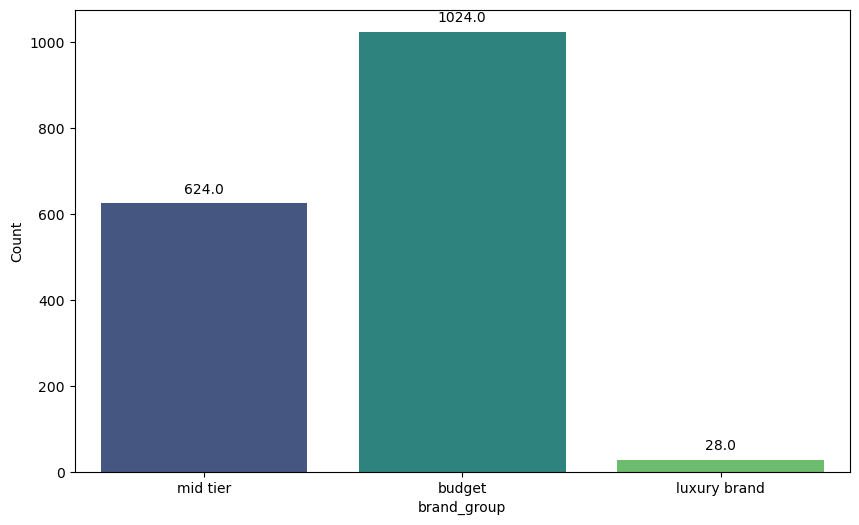

In [32]:

plt.figure(figsize=(10, 6))
sns.countplot(data=skin_care, x='brand_group', palette='viridis')

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')


plt.ylabel('Count')
plt.show()

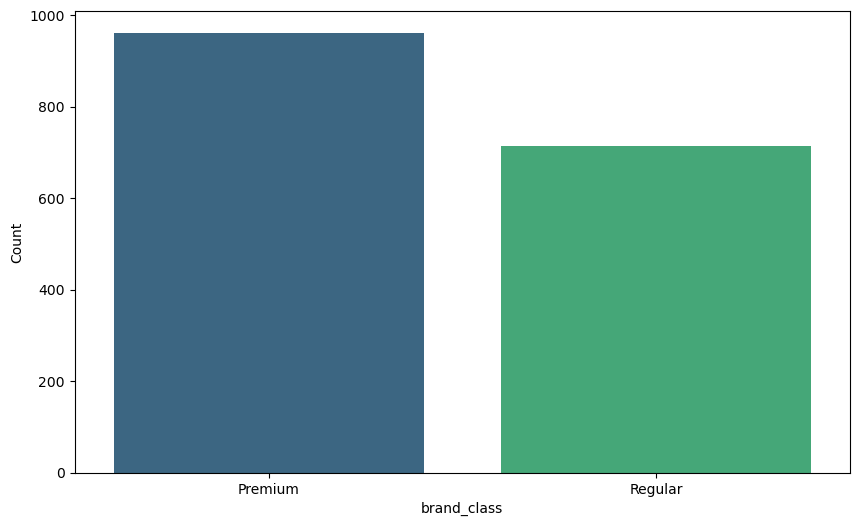

In [33]:
plt.figure(figsize=(10, 6))
sns.countplot(data=skin_care, x='brand_class', palette='viridis')
plt.ylabel('Count')
plt.show()

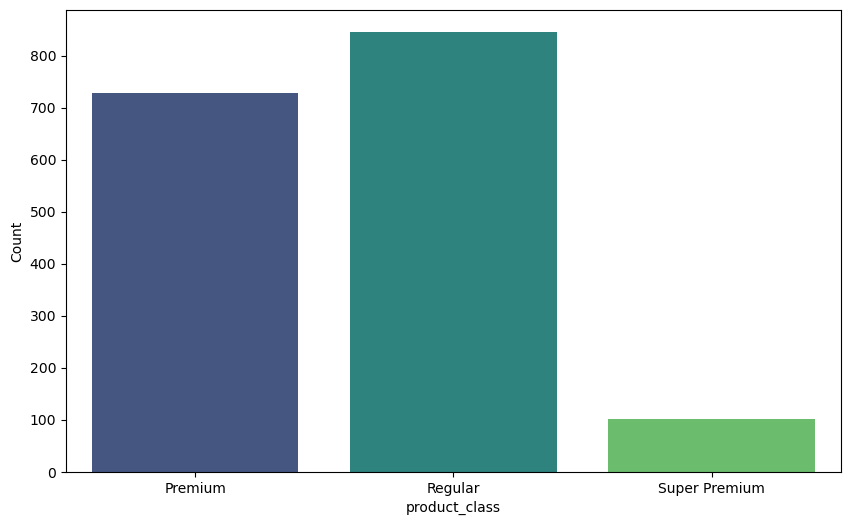

In [34]:
plt.figure(figsize=(10, 6))
sns.countplot(data=skin_care, x='product_class', palette='viridis')
plt.ylabel('Count')
plt.show()

In [35]:
moisturizer

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,...,noofratings,size_cv,price_cv,brand_group,percentile,product_class,brand_class,noofratings_cv,first_ingredient,second_ingredient
8961,Brightening Day Cream,ulta,USA,skincare,moisturizer,https://www.ulta.com/p/brightening-day-cream-p...,1633.38,ACURE,"Water (Aqua), Carthamus Tinctorius (Safflower)...",cream,...,74,51.0,1633.38,budget,0.422725,Regular,Regular,74.0,Water (Aqua),Carthamus Tinctorius (Safflower)
8962,Radically Rejuvenating SPF 30 Day Cream,ulta,USA,skincare,moisturizer,https://www.ulta.com/p/radically-rejuvenating-...,1633.38,ACURE,"Zinc Oxide 15%., Allantoin, Aloe Barbadensis (...",cream,...,199,51.0,1633.38,budget,0.422725,Regular,Regular,199.0,Zinc Oxide 15%.,Allantoin
8964,Essential Day Moisturizer Combination,ulta,USA,skincare,moisturizer,https://www.ulta.com/p/essential-day-moisturiz...,4248.92,Ahava,"Aqua (Mineral Spring Water), Hexyldecyl Laurat...",cream,...,69,51.0,4248.92,mid tier,0.832210,Premium,Regular,69.0,Aqua (Mineral Spring Water),Hexyldecyl Laurate
8965,Essential Day Moisturizer Normal to Dry,ulta,USA,skincare,moisturizer,https://www.ulta.com/p/essential-day-moisturiz...,4248.92,Ahava,"Aqua (Mineral Spring Water), Ethylhexyl Palmit...",cream,...,91,51.0,4248.92,mid tier,0.832210,Premium,Regular,91.0,Aqua (Mineral Spring Water),Ethylhexyl Palmitate
8966,Extreme Day Cream,ulta,USA,skincare,moisturizer,https://www.ulta.com/p/extreme-day-cream-xlsIm...,6536.80,Ahava,"Aqua(Mineral Spring Water), Sodium Hyaluronate...",cream,...,37,51.0,6536.80,mid tier,0.933558,Premium,Regular,37.0,Aqua(Mineral Spring Water),Sodium Hyaluronate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,"Collagen Luxe Day Moisturizer SPF 35 PA ++ - ""...",Sephora,India,skincare,moisturizer,https://sephora.nnnow.com/votre-unisex-adults-...,2270.00,Votre,"Daucus carota (Carrot seed ), Triticum vulgare...",cream,...,11,50.0,2270.00,budget,0.557053,Regular,Regular,11.0,Daucus carota (Carrot seed ),Triticum vulgare (Wheat germ )
9910,"""White Essence"" Lightening & Brightening Night...",Sephora,India,skincare,moisturizer,https://sephora.nnnow.com/votre-unisex-adults-...,2340.00,Votre,"Glycyrrhiza Glabra (Licorice), Rubus fruticosu...",cream,...,20,50.0,2340.00,budget,0.576793,Regular,Regular,20.0,Glycyrrhiza Glabra (Licorice),Rubus fruticosus (Blackberry)
9911,"Firming & Lifting ""Collagen Luxe"" Night Creme",Sephora,India,skincare,moisturizer,https://sephora.nnnow.com/votre-unisex-adults-...,2450.00,Votre,"Vitis vinifera (Grape seed), Hemidesmus indicu...",cream,...,9,50.0,2450.00,budget,0.593885,Regular,Regular,9.0,Vitis vinifera (Grape seed),Hemidesmus indicus ( Anantmool extract)
9912,"Multi Vitamin And Rejuvenating Night Creme - ""...",Sephora,India,skincare,moisturizer,https://sephora.nnnow.com/votre-unisex-adults-...,2450.00,Votre,"Olea Europaea (source of Vitamin E, Vitamin K...",cream,...,11,50.0,2450.00,budget,0.593885,Regular,Regular,11.0,Olea Europaea (source of Vitamin E,Vitamin K)


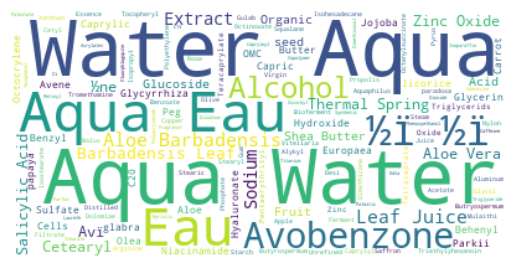

In [36]:
moisturizer_budget = moisturizer[moisturizer['brand_group'] == 'budget'] 
moisturizer_budget = moisturizer_budget.dropna(subset=['first_ingredient'])
wordcloud = WordCloud(background_color='white').generate(' '.join(moisturizer_budget['first_ingredient']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

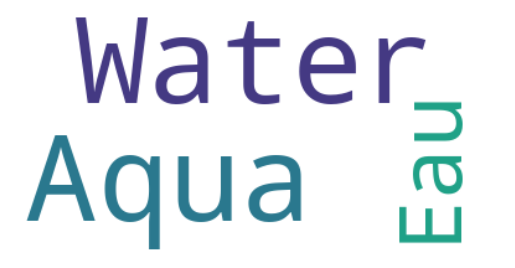

In [37]:
moisturizer_luxury = moisturizer[moisturizer['brand_group'] == 'luxury brand'] 
wordcloud = WordCloud(background_color='white').generate(' '.join(moisturizer_luxury['first_ingredient']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

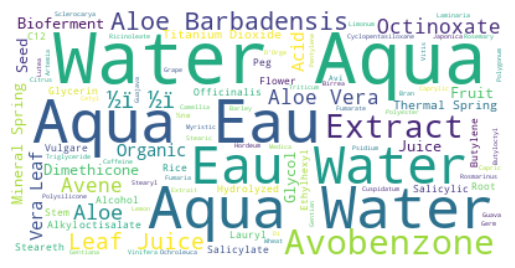

In [38]:
moisturizer_mid_tier = moisturizer[moisturizer['brand_group'] == 'mid tier'] 
wordcloud = WordCloud(background_color='white').generate(' '.join(moisturizer_mid_tier['first_ingredient']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

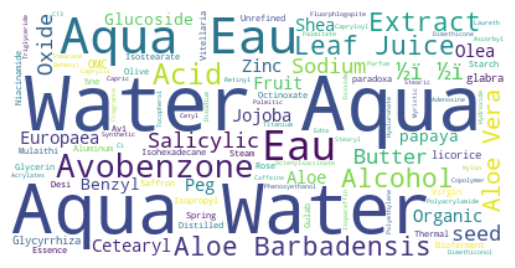

In [39]:
moisturizer_regular = moisturizer[moisturizer['product_class'] == 'Regular'] 
wordcloud = WordCloud(background_color='white').generate(' '.join(moisturizer_regular['first_ingredient']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show() 

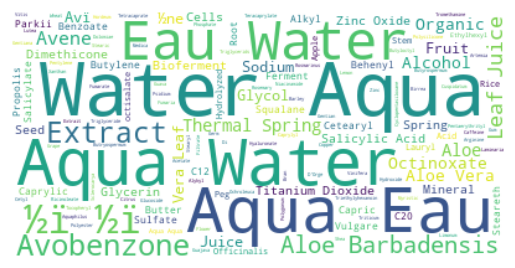

In [40]:
moisturizer_premium = moisturizer[moisturizer['product_class'] == 'Premium'] 
wordcloud = WordCloud(background_color='white').generate(' '.join(moisturizer_premium['first_ingredient']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show() 

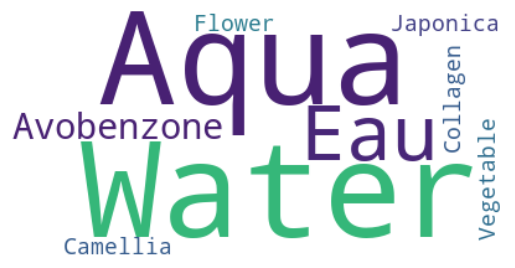

In [41]:
moisturizer_super_premium = moisturizer[moisturizer['product_class'] == 'Super Premium'] 
wordcloud = WordCloud(background_color='white').generate(' '.join(moisturizer_super_premium['first_ingredient']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show() 

In [42]:
serum = skin_care[skin_care['subcategory'] == 'serum']

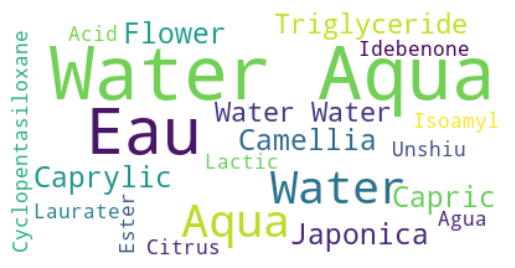

In [43]:
serum_super_premium = serum[serum['product_class'] == 'Super Premium'] 
wordcloud = WordCloud(background_color='white').generate(' '.join(serum_super_premium['first_ingredient']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show() 

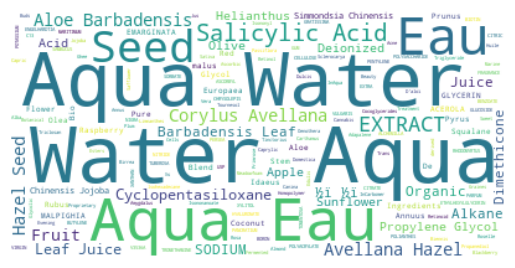

In [44]:
serum_premium = serum[serum['product_class'] == 'Premium'] 
wordcloud = WordCloud(background_color='white').generate(' '.join(serum_premium['first_ingredient']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show() 

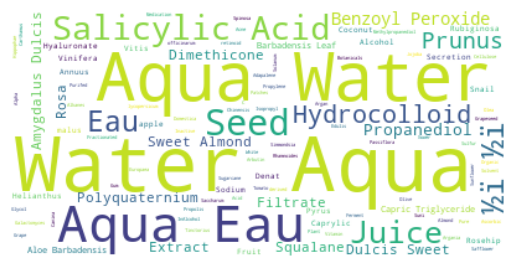

In [45]:
serum_regular = serum[serum['product_class'] == 'Regular'] 
wordcloud = WordCloud(background_color='white').generate(' '.join(serum_regular['first_ingredient']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show() 

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(skin_care['ingredients'], skin_care['brand_class'], test_size=0.2, random_state=42)


text_clf_svm = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf-svm', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=1000, random_state=42)),
])

text_clf_svm.fit(X_train, y_train)


predicted_svm = text_clf_svm.predict(X_test)


accuracy = np.mean(predicted_svm == y_test)
print(f"Accuracy on testing set: {accuracy:.2f}")


for true_label, predicted_label in zip(y_test, predicted_svm):
    print(f"True label: {true_label}, Predicted label: {predicted_label}")


from sklearn.metrics import classification_report
print("\nClassification Report:\n")
print(classification_report(y_test, predicted_svm))


Accuracy on testing set: 0.84
True label: Regular, Predicted label: Regular
True label: Premium, Predicted label: Premium
True label: Premium, Predicted label: Premium
True label: Premium, Predicted label: Premium
True label: Premium, Predicted label: Premium
True label: Regular, Predicted label: Premium
True label: Premium, Predicted label: Premium
True label: Premium, Predicted label: Premium
True label: Premium, Predicted label: Premium
True label: Premium, Predicted label: Regular
True label: Premium, Predicted label: Premium
True label: Premium, Predicted label: Premium
True label: Regular, Predicted label: Premium
True label: Regular, Predicted label: Regular
True label: Regular, Predicted label: Premium
True label: Premium, Predicted label: Premium
True label: Regular, Predicted label: Premium
True label: Regular, Predicted label: Regular
True label: Premium, Predicted label: Premium
True label: Regular, Predicted label: Regular
True label: Regular, Predicted label: Premium
True

In [49]:
for true_label, predicted_label in zip(y_test, predicted_svm):
    print(f"True label: {true_label}, Predicted label: {predicted_label}")

# Retrieve the feature names and coefficients
feature_names = text_clf_svm.named_steps['vect'].get_feature_names_out()
coefficients = text_clf_svm.named_steps['clf-svm'].coef_

# Create a DataFrame for the feature names and coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients[0]
})

# Sort by absolute value of the coefficient
feature_importance['Absolute_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)

# Display the top features
print("\nTop features influencing the classification:")
print(feature_importance[['Feature', 'Coefficient']].head(20))

True label: Regular, Predicted label: Regular
True label: Premium, Predicted label: Premium
True label: Premium, Predicted label: Premium
True label: Premium, Predicted label: Premium
True label: Premium, Predicted label: Premium
True label: Regular, Predicted label: Premium
True label: Premium, Predicted label: Premium
True label: Premium, Predicted label: Premium
True label: Premium, Predicted label: Premium
True label: Premium, Predicted label: Regular
True label: Premium, Predicted label: Premium
True label: Premium, Predicted label: Premium
True label: Regular, Predicted label: Premium
True label: Regular, Predicted label: Regular
True label: Regular, Predicted label: Premium
True label: Premium, Predicted label: Premium
True label: Regular, Predicted label: Premium
True label: Regular, Predicted label: Regular
True label: Premium, Predicted label: Premium
True label: Regular, Predicted label: Regular
True label: Regular, Predicted label: Premium
True label: Regular, Predicted lab